In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
from scipy.optimize import minimize, least_squares
from typing import Tuple
import itertools as it
from skimage.util import img_as_ubyte
import skimage
import torch
import torch.nn.functional as func

In [9]:
name = "T_S04856"
# name = "T_S04910"
# name = "T_S04911"
# name = "T_S04912"
# name = "T_S04923"

png_file = Path(f"../../data/seathru/D3/D3/linearPNG/{name}.png")
tif_file = Path(f"../../data/seathru/D3/D3/depth/depth{name}.tif")

In [10]:
clusters = 10

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cpu'

In [12]:
def uint8_2_double(array: np.ndarray):
    return array.astype(np.float64) / 255.0

def double_2_uint8(array: np.ndarray):
    return (array * 255).astype(np.uint8)

In [13]:
def imshow(img: np.ndarray, color_channel="rgb"):


    if img.dtype == np.float64 and len(img.shape) == 3:
        img = double_2_uint8(img)

    if color_channel == "bgr":
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif color_channel == "hsv":
        img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)

    plt.imshow(img)

    if len(img.shape) == 2:
        plt.colorbar()

In [15]:
cv2.imread(png_file)

In [14]:
png = uint8_2_double(cv2.imread(png_file))
height, width, _ = png.shape

imshow(png, color_channel="bgr")

AttributeError: 'NoneType' object has no attribute 'astype'

In [ ]:
png.dtype

dtype('float64')

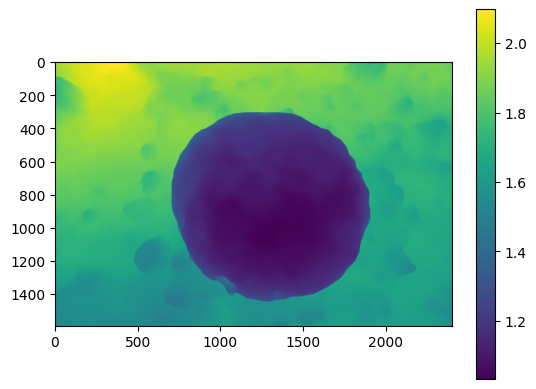

In [ ]:
tif_image = Image.open(tif_file)
tif = np.array(tif_image)
tif = cv2.resize(tif, (width, height),  interpolation = cv2.INTER_NEAREST)

imshow(tif)

In [ ]:
png.shape, tif.shape

((1596, 2400, 3), (1596, 2400))

In [ ]:
tif.min(), tif.max()

(np.float32(1.0321687), np.float32(2.0977757))

In [ ]:
tif_flat = tif.flatten()

tif_flat.shape

(3830400,)

## Backscatter Estimation

In [ ]:
# kmeans = KMeans(n_clusters=clusters, random_state=0, n_init="auto").fit(tif_flat[tif_flat != 0].reshape(-1, 1))
# labels = np.zeros(tif_flat.shape, dtype=np.uint8)
# labels[tif_flat != 0] = kmeans.labels_
# labels[tif_flat == 0] = 255 # Use 255 to represent nan
# means = np.array(kmeans.cluster_centers_).flatten()
# means_args = np.argsort(means)

# labels_new = np.zeros_like(labels)
# labels_new[labels == 255] = clusters + 1

# for current_label in range(clusters):
#     new_label = np.nonzero(means_args == current_label)[0]
#     labels_new[labels == current_label] = new_label

# labels = labels_new.reshape((height, width))
# imshow(labels)

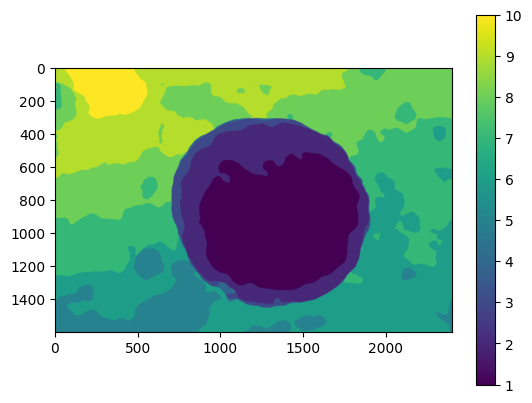

In [ ]:
_, edges = np.histogram(tif_flat, clusters)

labels = np.zeros(tif.shape, dtype=np.uint8)
for i in range(clusters + 1):
    labels[np.logical_and(tif <= edges[i], labels == 0)] = i

imshow(labels)

In [ ]:
np.unique_counts(labels)

UniqueCountsResult(values=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8), counts=array([624129, 367726,  80555,  11589, 263087, 699030, 563987, 637811,
       473182, 109304]))

In [ ]:
dark_pixels = []
z_values = []

for i in range(1, clusters + 1):
    mask = labels == i
    filtered = png * mask[:, :, np.newaxis]

    b = png[:, :, 0]
    g = png[:, :, 1]
    r = png[:, :, 2]

    b_filtered = b[mask].flatten()
    g_filtered = g[mask].flatten()
    r_filtered = r[mask].flatten()

    pixels = np.array([[b,g,r] for b,g,r in zip(b_filtered, g_filtered , r_filtered)])
    pixel_means = pixels.mean(axis=1)
    idx = np.argsort(pixel_means)[:int(round(float(len(pixel_means)) * 0.01))]
    selected_pixels = pixels[idx]

    filtered_tif = tif[mask].flatten()
    z = filtered_tif[idx]

    dark_pixels.extend(selected_pixels.tolist())
    z_values.extend(z.tolist())
    # break

dark_pixels = np.array(dark_pixels)
z_values = np.array(z_values)

In [ ]:
idx

array([44841, 44842, 59397, ..., 11092, 30904, 58520], shape=(1093,))

In [ ]:
len(idx) / pixels.shape[0]

0.009999634048159262

In [ ]:
pixels <= np.percentile(pixels, 1, axis=0), pixels[0],  np.percentile(pixels, 1, axis=0)

(array([[False, False,  True],
        [False, False,  True],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]], shape=(109304, 3)),
 array([0.02352941, 0.03137255, 0.00392157]),
 array([0.01960784, 0.02745098, 0.00392157]))

In [ ]:
png.shape, 1596 * 2400

((1596, 2400, 3), 3830400)

In [ ]:
dark_pixels.shape[0] / (1596 * 2400), z_values.shape

(0.01, (38304,))

In [ ]:
tif.min(), tif.max()

(np.float32(1.0321687), np.float32(2.0977757))

In [ ]:
z_values

array([1.03710938, 1.03710938, 1.03710926, ..., 2.0703125 , 1.99540734,
       1.99534512], shape=(38304,))

In [ ]:
def estimate_backscatter(B_inf: float, beta_B: float, J_prime: float, beta_D_prime: float, z):
    return B_inf * (1 - np.exp(- beta_B * z)) + (J_prime * np.exp(- beta_D_prime * z))

In [ ]:
def optimize_estimate_backscatter(arguments: Tuple[float, float, float, float], B_hat: np.ndarray, z: np.ndarray):
    B_inf, beta_B, J_prime, beta_D_prime = arguments

    return estimate_backscatter(B_inf, beta_B, J_prime, beta_D_prime, z) - B_hat

In [ ]:
def leastsquares_estimate_backscatter(dark_pixels: np.ndarray, z_values: np.ndarray, color_channel: int, starts=10):
    lo = np.array([0, 0, 0, 0])
    hi = np.array([1, 5, 1, 5])

    best_params = None
    best_loss = None

    for _ in range(starts):
        starting_point = np.random.random_sample(4)
        starting_point[1] *= 5
        starting_point[3] *= 5

        print(starting_point)

        try:
            result = least_squares(optimize_estimate_backscatter, starting_point, args=(dark_pixels[:, color_channel], z_values), loss='soft_l1', bounds=(lo, hi))
        except ValueError:
            continue
        
        params = result.x
        loss = np.linalg.norm(optimize_estimate_backscatter(params, dark_pixels[:, color_channel], z_values))

        print(loss, params)

        if best_loss is None or loss < best_loss:
            best_params = params
            best_loss = loss
            
    return best_params, best_loss

In [ ]:
# dsssdfsd

In [ ]:
dark_pixels

array([[0.        , 0.00392157, 0.        ],
       [0.        , 0.00392157, 0.        ],
       [0.        , 0.00392157, 0.        ],
       ...,
       [0.01960784, 0.02745098, 0.00392157],
       [0.01960784, 0.02745098, 0.00392157],
       [0.01960784, 0.02745098, 0.00392157]], shape=(38304, 3))

In [ ]:
b_args, loss = leastsquares_estimate_backscatter(dark_pixels, z_values, 0)

b_args, loss

[0.56652954 1.00344455 0.69702708 0.96176745]
0.6205524973487823 [9.99999856e-01 7.24255493e-03 2.69754451e-35 4.94876153e+00]
[0.79150686 0.62616977 0.53347799 0.65796248]
0.6205524971616331 [9.99999999e-01 7.24255566e-03 3.84766592e-32 4.99931805e+00]
[0.58598221 3.36098589 0.55063419 3.79781765]
0.6205524971605105 [1.00000000e+00 7.24255407e-03 1.27928306e-32 4.99999864e+00]
[0.55797979 0.94289592 0.12379268 3.55116961]
0.6205524971606182 [1.00000000e+00 7.24255461e-03 1.72248809e-36 4.99999992e+00]
[0.80612342 1.25725592 0.82571207 2.08062967]
0.6205524971605143 [1.00000000e+00 7.24255397e-03 6.35635076e-38 4.99441772e+00]
[0.65950884 2.42376216 0.32892448 2.1691499 ]
0.6205524972523082 [9.99999930e-01 7.24255439e-03 2.25071850e-33 4.99357116e+00]
[0.78994161 3.48627098 0.86150155 1.64896303]
0.6205524971605153 [1.00000000e+00 7.24255412e-03 4.93182374e-33 4.99999541e+00]
[0.17804389 4.346299   0.07730795 2.087361  ]
0.6205524971605172 [1.00000000e+00 7.24255414e-03 2.83689804e-38 

(array([1.00000000e+00, 7.24255407e-03, 1.27928306e-32, 4.99999864e+00]),
 np.float64(0.6205524971605105))

In [ ]:
g_args, loss = leastsquares_estimate_backscatter(dark_pixels, z_values, 1)

g_args, loss

[0.22203159 1.33591866 0.67956121 0.54602479]
0.8058074199566848 [1.00000000e+00 1.16322358e-02 1.25476924e-29 4.87719160e+00]
[0.15899925 1.28968671 0.4440672  4.55104732]
0.8058074199599278 [9.99999997e-01 1.16322386e-02 1.40293279e-31 4.68140096e+00]
[0.18248941 4.28744519 0.16641078 4.95807724]
0.8058074199564209 [1.00000000e+00 1.16322366e-02 7.35622958e-36 4.85137549e+00]
[0.34371428 4.62170326 0.39990988 3.66592178]
0.8058074199595058 [9.99999998e-01 1.16322385e-02 5.23868772e-33 4.99205783e+00]
[0.16378212 3.14866395 0.09069548 1.3009745 ]
0.8058074199565763 [1.00000000e+00 1.16322370e-02 1.47915349e-38 4.50632770e+00]
[0.21292998 3.02552644 0.52694362 3.89455927]
0.805807419956444 [1.00000000e+00 1.16322364e-02 2.32483486e-34 4.97187544e+00]
[0.42526431 2.40721137 0.76898023 0.21785435]
0.8058074199654414 [9.99999993e-01 1.16322398e-02 4.50609117e-31 4.87659708e+00]
[0.07569114 0.67818725 0.55225624 0.39572046]
0.8058074199566378 [1.00000000e+00 1.16322371e-02 7.32809252e-36 4

(array([1.00000000e+00, 1.16322366e-02, 7.35622958e-36, 4.85137549e+00]),
 np.float64(0.8058074199564209))

In [ ]:
r_args, loss = leastsquares_estimate_backscatter(dark_pixels, z_values, 2)

r_args, loss

[0.79792994 1.61558265 0.55088826 0.50743935]
0.3247438682863487 [9.99999996e-01 1.61566164e-03 1.21348468e-90 4.99962059e+00]
[0.6008255  3.96619345 0.25668984 1.9223256 ]
0.3247438682865839 [9.99999989e-01 1.61566162e-03 2.88155191e-95 4.99781680e+00]
[0.68552375 1.27993324 0.55875371 0.11751791]
0.32474386852011106 [9.99993702e-01 1.61567178e-03 3.32515167e-96 4.99929871e+00]
[0.78190054 0.15455619 0.84083617 4.27566492]
0.3247438682865943 [9.99999989e-01 1.61566162e-03 2.98291498e-94 4.99963462e+00]
[0.47121012 2.7006036  0.2437164  2.10982832]
0.32474386828636154 [9.99999995e-01 1.61566160e-03 3.56216199e-97 4.99903926e+00]
[0.77531572 3.96227244 0.63816129 2.81132557]
0.3247438682862047 [9.99999999e-001 1.61566159e-003 7.75774227e-103 4.99803238e+000]
[0.14024926 0.23005601 0.79402702 0.35815068]
0.32474386828621365 [9.99999999e-01 1.61566159e-03 1.73939658e-98 4.99628762e+00]
[0.26451236 2.21943354 0.87278644 4.95670669]
0.32474386828622276 [1.0000000e+00 1.6156617e-03 4.5742855

(array([1.00000000e+00, 1.61566000e-03, 2.07996863e-96, 4.99943809e+00]),
 np.float64(0.3247438682860638))

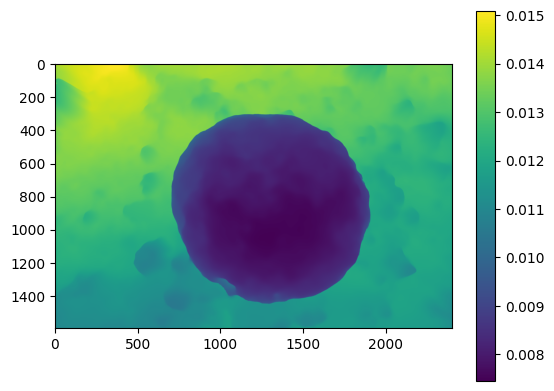

In [ ]:
B_b = estimate_backscatter(b_args[0], b_args[1], b_args[2], b_args[3], tif_flat).reshape((height, width))

imshow(B_b)

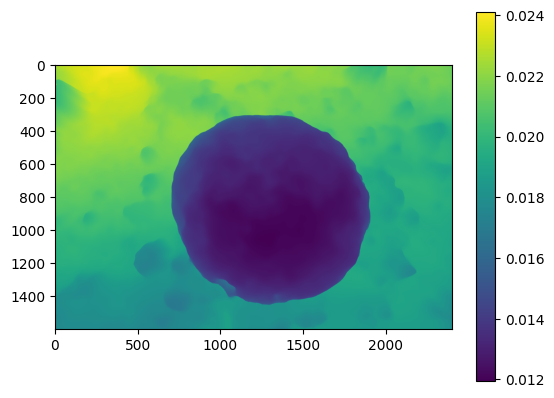

In [ ]:
B_g = estimate_backscatter(g_args[0], g_args[1], g_args[2], g_args[3], tif_flat).reshape((height, width))

imshow(B_g)

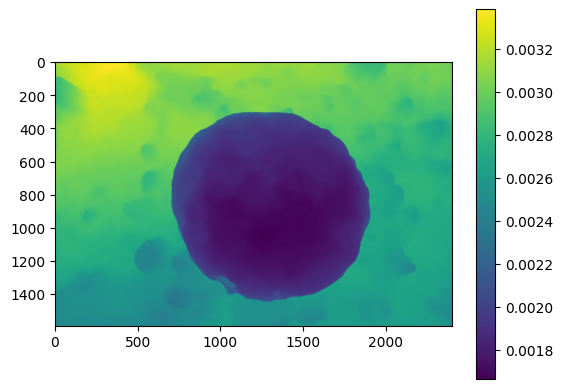

In [ ]:
B_r = estimate_backscatter(r_args[0], r_args[1], r_args[2], r_args[3], tif_flat).reshape((height, width))

imshow(B_r)

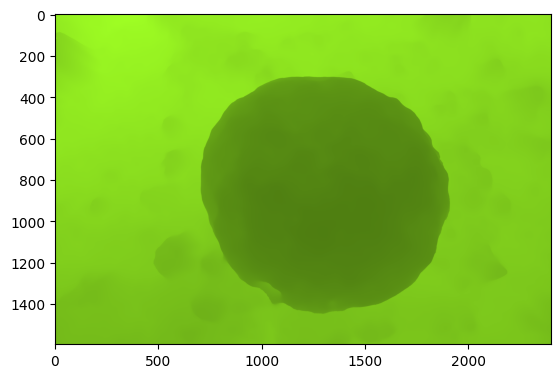

In [ ]:
backscatter = np.zeros((height, width, 3), dtype=np.float64)

backscatter[:, :, 0] = B_b
backscatter[:, :, 1] = B_g
backscatter[:, :, 2] = B_r

imshow(backscatter / backscatter.max())

In [ ]:
png

array([[[0.02745098, 0.04705882, 0.00784314],
        [0.02745098, 0.04705882, 0.00784314],
        [0.02745098, 0.04313725, 0.00784314],
        ...,
        [0.05882353, 0.09411765, 0.01960784],
        [0.05882353, 0.09411765, 0.01960784],
        [0.05882353, 0.09411765, 0.01960784]],

       [[0.02352941, 0.03921569, 0.00784314],
        [0.02352941, 0.03529412, 0.00392157],
        [0.02352941, 0.03529412, 0.00392157],
        ...,
        [0.05882353, 0.09803922, 0.01960784],
        [0.05882353, 0.09803922, 0.01960784],
        [0.05882353, 0.09803922, 0.01960784]],

       [[0.02352941, 0.03529412, 0.00392157],
        [0.01960784, 0.03137255, 0.00392157],
        [0.02352941, 0.03529412, 0.00392157],
        ...,
        [0.05490196, 0.09411765, 0.01960784],
        [0.05490196, 0.09411765, 0.01960784],
        [0.05490196, 0.09411765, 0.01960784]],

       ...,

       [[0.04705882, 0.0745098 , 0.01176471],
        [0.04313725, 0.0745098 , 0.01568627],
        [0.03137255, 0

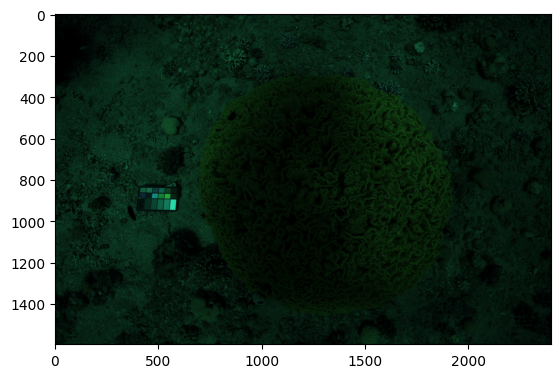

In [ ]:
direct_signal = png - backscatter

# sig_min_b = direct_signal[:, :, 0].min()
# sig_min_g = direct_signal[:, :, 1].min()
# sig_min_r = direct_signal[:, :, 2].min()

# if sig_min_b > 0:
#     sig_min_b = 0

# if sig_min_g > 0:
#     sig_min_g = 0

# if sig_min_r > 0:
#     sig_min_r = 0

# direct_signal[:, :, 0] = direct_signal[:, :, 0] - sig_min_b
# direct_signal[:, :, 1] = direct_signal[:, :, 1] - sig_min_g
# direct_signal[:, :, 2] = direct_signal[:, :, 2] - sig_min_r

direct_signal = np.clip(direct_signal, 0, 1)

imshow(direct_signal, color_channel="bgr")

In [ ]:
direct_signal

array([[[0.01339426, 0.02457874, 0.00469012],
        [0.01339426, 0.02457874, 0.00469012],
        [0.01338871, 0.02064832, 0.00468886],
        ...,
        [0.04547491, 0.07276536, 0.01661449],
        [0.04547687, 0.07276849, 0.01661493],
        [0.04548227, 0.07277708, 0.01661614]],

       [[0.0094727 , 0.0167356 , 0.00469012],
        [0.0094727 , 0.01281403, 0.00076855],
        [0.00946714, 0.01280518, 0.00076729],
        ...,
        [0.04547491, 0.07668693, 0.01661449],
        [0.04547687, 0.07669006, 0.01661493],
        [0.04548227, 0.07669865, 0.01661614]],

       [[0.00947533, 0.01281824, 0.00076914],
        [0.00555377, 0.00889667, 0.00076914],
        [0.00946993, 0.01280963, 0.00076792],
        ...,
        [0.04155327, 0.07276525, 0.01661447],
        [0.04155806, 0.07277288, 0.01661555],
        [0.04156095, 0.07277749, 0.0166162 ]],

       ...,

       [[0.0360652 , 0.05691191, 0.00930172],
        [0.03214364, 0.05691191, 0.01322329],
        [0.02037788, 0

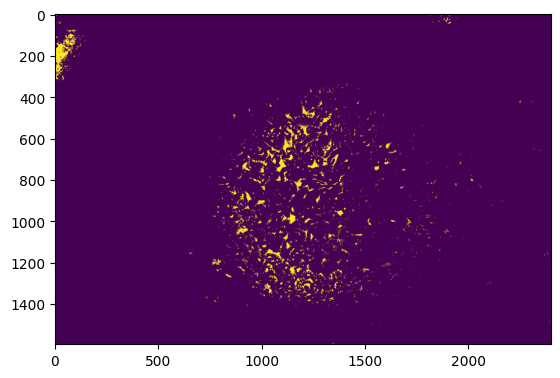

In [ ]:
plt.imshow((png < backscatter)[:, :, 0])

In [ ]:
np.savez_compressed(f"./output/DS_{name}.npz", direct_signal=direct_signal.astype(np.float32))

direct_signal.shape

(1596, 2400, 3)

## Attenuation Coefficient Estimation

### Coarse Estimate of $\beta_c^D(z)$

In [ ]:
epsilon_percent = 0.1
convergence_threshold = 0.001
f = 2.0
p = 0.1

In [ ]:
epsilon = (tif.max() - tif_flat[tif_flat != 0].min()) * epsilon_percent

epsilon

np.float32(0.1065607)

In [ ]:
def pad_tensor(tensor: torch.Tensor, top: int, right: int, left: int, bottom: int) -> torch.Tensor:
    dim = len(tensor.shape)

    if len(tensor.shape) == 2:
        tensor = tensor[:, :, None]

    height, width, channels = tensor.shape

    new_height = height + top + bottom
    new_width = width + right + left

    bottom_idx = new_height - bottom
    right_idx = new_width - right

    padded = torch.zeros((new_height, new_width, channels), device=device)
    padded[top:bottom_idx, left:right_idx, :] = tensor

    if dim == 2:
        return padded[:, :]
    else:
        return padded


In [ ]:
def pad_direction(tensor: torch.Tensor):
    if len(tensor.shape) == 2:
        tensor = tensor[:, :, None]

    height, width, channels = tensor.shape

    direction = torch.zeros((height + 2, width + 2, 4, channels), device=device)
    direction[:, :, 0, :] = pad_tensor(tensor, 2, 1, 1, 0)
    direction[:, :, 1, :] = pad_tensor(tensor, 1, 2, 0, 1)
    direction[:, :, 2, :] = pad_tensor(tensor, 0, 1, 1, 2)
    direction[:, :, 3, :] = pad_tensor(tensor, 1, 0, 2, 1)

    return direction

In [ ]:
direct_signal_tensor = pad_tensor(torch.as_tensor(direct_signal, device=device), 1, 1, 1, 1)
a_values_tensor = direct_signal_tensor
depths_tensor = torch.as_tensor(tif, device=device)
diff_depth_map_tensor = torch.abs(torch.dstack([pad_tensor(depths_tensor, 1, 1, 1, 1)] * 4) - pad_direction(depths_tensor).squeeze())
softmax = func.softmax(-diff_depth_map_tensor, dim=-1)
weights = torch.stack([softmax] * 3, dim=-1)

for i in range(100):
    a_values_tensor = pad_direction(a_values_tensor[1:-1, 1:-1, :])
    a_values_tensor = torch.sum(weights * a_values_tensor, axis=2)
    a_values_tensor = (1 - p) * a_values_tensor + p * direct_signal_tensor

a_values_tensor.shape

torch.Size([1598, 2402, 3])

In [ ]:
a_values = a_values_tensor[1:-1, 1:-1, :].detach().cpu().numpy()

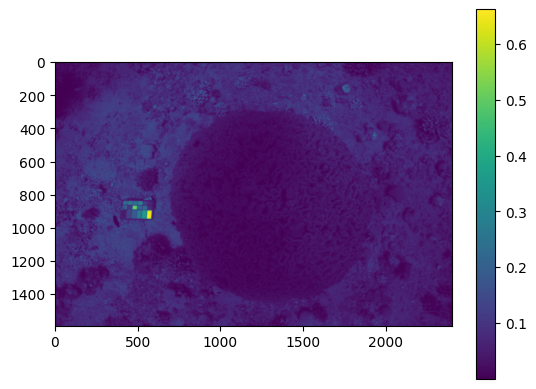

In [ ]:
imshow(a_values[:, :, 0])

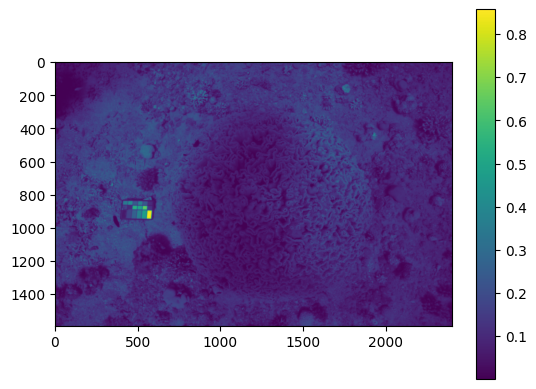

In [ ]:
imshow(a_values[:, :, 1])

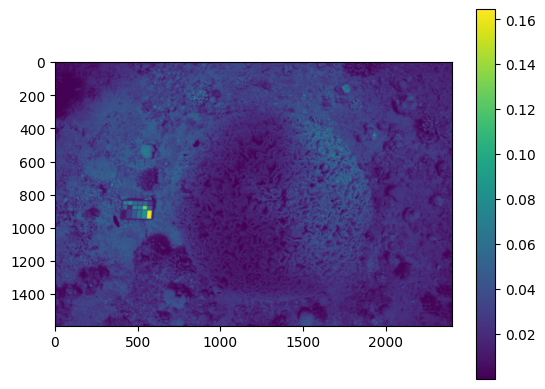

In [ ]:
imshow(a_values[:, :, 2])

1.7155205


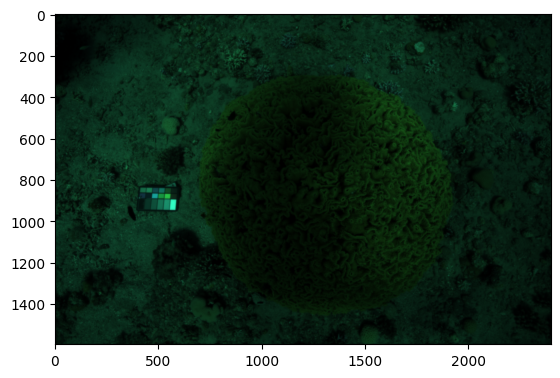

In [ ]:
local_illuminant_map = f * a_values

print(local_illuminant_map.max())
imshow(local_illuminant_map / local_illuminant_map.max(), color_channel="bgr")

In [ ]:
np.sort(local_illuminant_map.flatten()), (local_illuminant_map[:, :, 0] <= 0).mean()

(array([5.9687340e-09, 6.4621060e-09, 7.0065833e-09, ..., 1.7140619e+00,
        1.7149191e+00, 1.7155205e+00], shape=(11491200,), dtype=float32),
 np.float64(0.0))

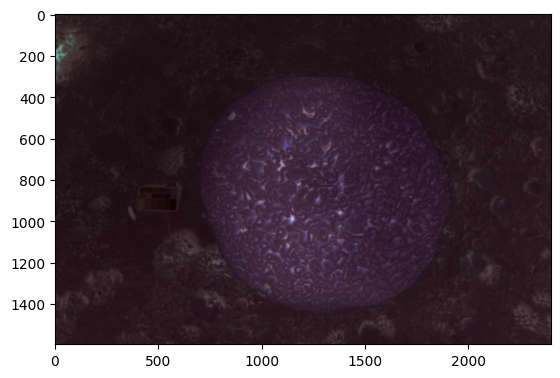

In [ ]:
beta_d_coarse = np.zeros_like(local_illuminant_map)

beta_d_coarse[:, :, 0] = - np.log(local_illuminant_map[:, :, 0]) / tif
beta_d_coarse[:, :, 1] = - np.log(local_illuminant_map[:, :, 1]) / tif
beta_d_coarse[:, :, 2] = - np.log(local_illuminant_map[:, :, 2]) / tif

beta_min = beta_d_coarse.min()
beta_max = beta_d_coarse.max() - beta_min
imshow((beta_d_coarse - beta_min) / beta_max, color_channel="bgr")

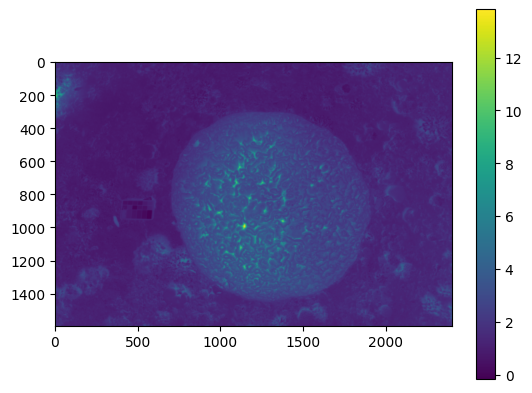

In [ ]:
imshow(beta_d_coarse[:, :, 0])

In [ ]:
np.sort(beta_d_coarse[:, :, 0].flatten()), np.isnan(beta_d_coarse[:,:,0].flatten()).mean(), (beta_d_coarse[:,:,0].flatten() < 0).mean()

(array([-0.16135822, -0.1613065 , -0.16115145, ..., 13.783914  ,
        13.798876  , 13.830997  ], shape=(3830400,), dtype=float32),
 np.float64(0.0),
 np.float64(0.00039865288220551376))

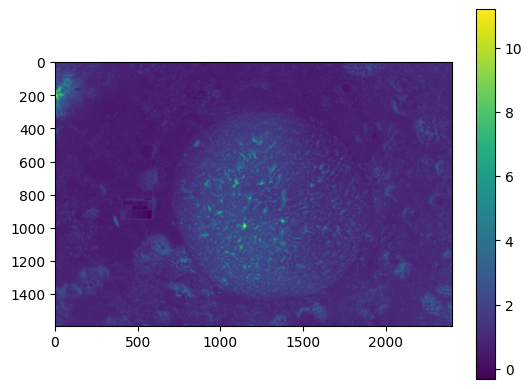

In [ ]:
imshow(beta_d_coarse[:, :, 1])

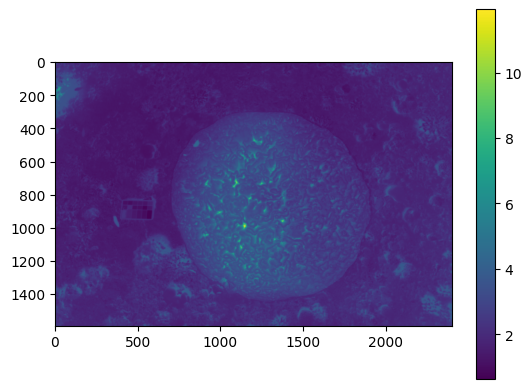

In [ ]:
imshow(beta_d_coarse[:, :, 2])

### Refined Estimate of $\beta_c^D(z)$

In [ ]:
def compute_beta_D(a: float, b: float, c: float, d: float, z: np.ndarray) -> np.ndarray:
    return a * np.exp(b * z) + c * np.exp(d * z)

In [ ]:
def optimize_compute_beta_D(args: Tuple[float, float, float, float], E: np.ndarray, z: np.ndarray) -> np.ndarray[float]:
    a, b, c, d = args
    beta_D = compute_beta_D(a, b, c, d, z)
    z_hat = -np.log(E) / beta_D

    return (z - z_hat).flatten()

In [ ]:
def partial_a(a: float, b: float, c: float, d: float, local_illuminant_map: np.ndarray, z: np.ndarray):
    E_log = np.log(local_illuminant_map)
    Q = compute_beta_D(a, b, c, d, z)*z
    exp_bz = np.exp(b * z)

    # frac1 = (exp_bz * E_log * z) / (denom ** 2)
    # frac2 = (E_log / denom) + z

    return (2*E_log + 2*Q).T @ (z * exp_bz)

In [ ]:
def partial_b(a: float, b: float, c: float, d: float, local_illuminant_map: np.ndarray, z: np.ndarray):
    E_log = np.log(local_illuminant_map)
    Q = compute_beta_D(a, b, c, d, z)*z
    exp_bz = np.exp(b * z)

    # frac1 = (exp_bz * E_log * z) / (denom ** 2)
    # frac2 = (E_log / denom) + z

    return (2*E_log + 2*Q).T @ (z * exp_bz * a *z)

In [ ]:
def partial_c(a: float, b: float, c: float, d: float, local_illuminant_map: np.ndarray, z: np.ndarray):
    E_log = np.log(local_illuminant_map)
    Q = compute_beta_D(a, b, c, d, z)*z
    exp_dz = np.exp(d * z)

    # frac1 = (exp_dz * E_log) / (denom ** 2)
    # frac2 = (E_log / denom) + z

    return (2*E_log + 2*Q).T @ (z * exp_dz)

In [ ]:
def partial_d(a: float, b: float, c: float, d: float, local_illuminant_map: np.ndarray, z: np.ndarray):
    E_log = np.log(local_illuminant_map)
    Q = compute_beta_D(a, b, c, d, z)*z
    exp_dz = np.exp(d * z)

    # frac1 = (exp_dz * E_log) / (denom ** 2)
    # frac2 = (E_log / denom) + z

    return (2*E_log + 2*Q).T @ (z * exp_dz * c *z) 

In [ ]:
def grad_descent(a: float, b: float, c: float, d: float, local_illuminant_map: np.ndarray, z: np.ndarray, channel: int, lr=0.0000000001):
    e = 0.00000001
    na = a - lr * partial_a(a,b,c,d,local_illuminant_map,z)
    #print("a", a)
    na = np.clip(na,e,np.inf)
    
    nb = b - lr * partial_b(a,b,c,d,local_illuminant_map,z)
    #print("b", b)
    nb = np.clip(nb,-np.inf,-e)

    #print(a,b,c,d)
    nc = c - lr * partial_c(a,b,c,d,local_illuminant_map,z)
    #print("c", c)
    nc = np.clip(nc,e,np.inf)

    nd = d - lr * partial_b(a,b,c,d,local_illuminant_map,z)
    #print("d", d)
    nd = np.clip(nd,-np.inf,-e)

    return na,nb,nc,nd

In [ ]:
b_local_illuminant_map_flat = local_illuminant_map[:, :, 0].flatten()

In [ ]:
tif.max()

np.float32(2.0977757)

In [ ]:
b_args = (0.1,-.1,.1,-.1)

In [ ]:
# b_args = (0.1,-.1,.1,-.1)
print(np.linalg.norm((optimize_compute_beta_D(b_args, local_illuminant_map[:, :, 0], tif))))
for i in range(10000):
    b_args = grad_descent(*b_args, b_local_illuminant_map_flat, tif_flat, 0,lr=0.00000001)
    print(i, np.linalg.norm(optimize_compute_beta_D(b_args, local_illuminant_map[:, :, 0], tif)), b_args)

1015.19745
0 1015.2016 (np.float32(5.9139338), np.float32(-1.26838), np.float32(5.9139338), np.float32(-1.26838))
1 1015.20575 (np.float32(5.91438), np.float32(-1.2684289), np.float32(5.91438), np.float32(-1.2684289))
2 1015.2098 (np.float32(5.9148264), np.float32(-1.2684777), np.float32(5.9148264), np.float32(-1.2684777))
3 1015.21405 (np.float32(5.9152727), np.float32(-1.2685266), np.float32(5.9152727), np.float32(-1.2685266))
4 1015.2182 (np.float32(5.9157186), np.float32(-1.2685753), np.float32(5.9157186), np.float32(-1.2685753))
5 1015.22235 (np.float32(5.9161644), np.float32(-1.2686241), np.float32(5.9161644), np.float32(-1.2686241))
6 1015.22656 (np.float32(5.9166102), np.float32(-1.2686728), np.float32(5.9166102), np.float32(-1.2686728))
7 1015.2306 (np.float32(5.9170556), np.float32(-1.2687215), np.float32(5.9170556), np.float32(-1.2687215))
8 1015.2346 (np.float32(5.917501), np.float32(-1.2687702), np.float32(5.917501), np.float32(-1.2687702))
9 1015.23883 (np.float32(5.91794

KeyboardInterrupt: 

In [ ]:
b_args

(np.float32(99.95813),
 np.float32(-2.4094634),
 np.float32(0.061675444),
 np.float32(-2.191817))

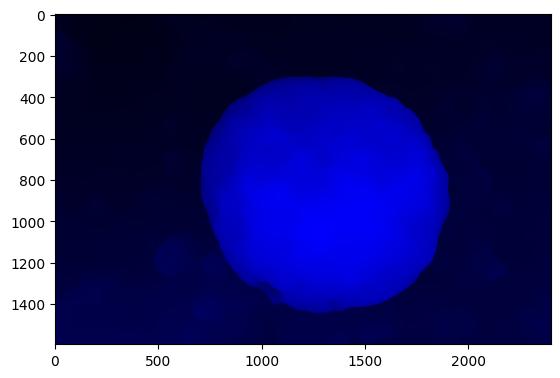

In [ ]:
beta_d = np.zeros_like(local_illuminant_map)

beta_d[:, :, 0] = compute_beta_D(b_args[0], b_args[1], b_args[2], b_args[3], tif)
# beta_d[:, :, 1] = compute_beta_D(local_illuminant_params_g[0], local_illuminant_params_g[1], local_illuminant_params_g[2], local_illuminant_params_g[3], tif)
# beta_d[:, :, 2] = compute_beta_D(local_illuminant_params_r[0], local_illuminant_params_r[1], local_illuminant_params_r[2], local_illuminant_params_r[3], tif)

beta_d_min = beta_d.min()
beta_d_max = beta_d.max() - beta_d_min
imshow((beta_d - beta_d_min) / beta_d_max, color_channel="bgr")

In [ ]:
J = np.zeros_like(direct_signal)

J[:, :, 0] = direct_signal[:, :, 0] * np.exp(beta_d[:, :, 0] * tif)
J[:, :, 1] = direct_signal[:, :, 1] * np.exp(beta_d[:, :, 1] * tif)
J[:, :, 2] = direct_signal[:, :, 2] * np.exp(beta_d[:, :, 2] * tif)

# J[:, :, 0] = J[:, :, 0] / J[:, :, 0].max()
# J[:, :, 1] = J[:, :, 1] / J[:, :, 1].max()
# J[:, :, 2] = J[:, :, 2] / J[:, :, 2].max()

J = J / J.max()

imshow(J, color_channel="bgr")

NameError: name 'beta_d' is not defined

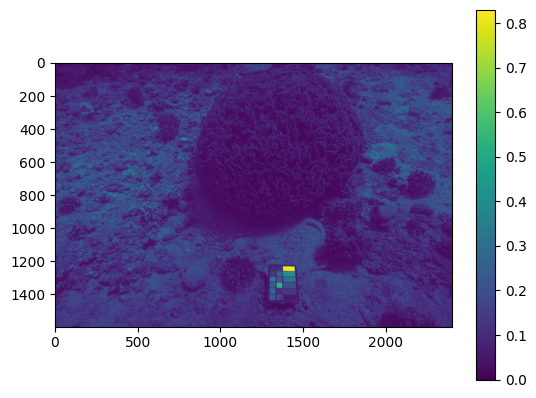

In [ ]:
imshow(J[:, :, 0])

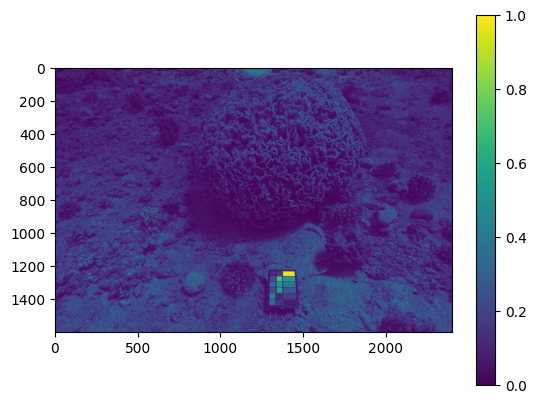

In [ ]:
imshow(J[:, :, 1])

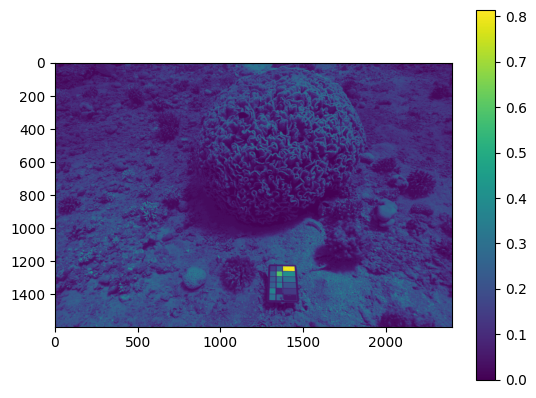

In [ ]:
imshow(J[:, :, 2])

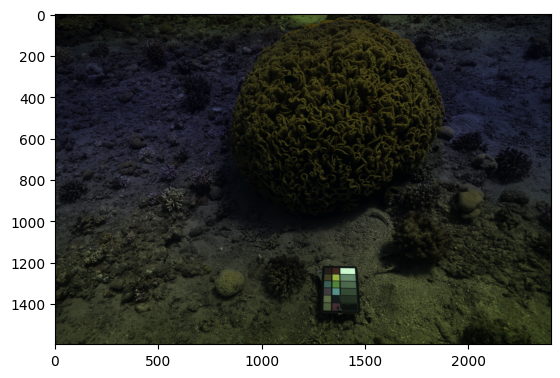

In [ ]:
J_8 = double_2_uint8(J)

imshow(J, color_channel="bgr")

In [ ]:
def gray_world(image):
    """
    White balance image using Gray-world algorithm.
    """
    access_gw = ((image * (image.mean() / image.mean(axis=(0, 1))))
             .clip(0, 255))
    
    return access_gw

In [ ]:
def scale(img):
    return img_as_ubyte((img - np.min(img)) / (np.max(img) - np.min(img)))

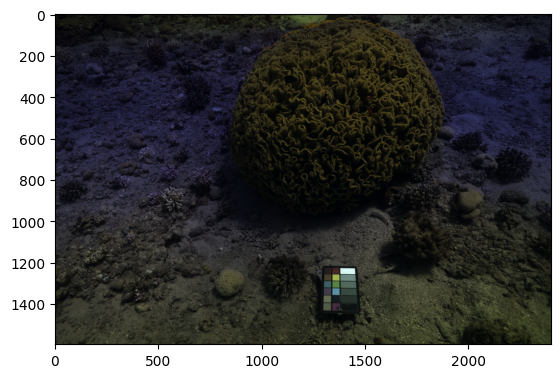

In [ ]:
J_gray_world = scale(gray_world(J_8.astype(np.float64)))

imshow(J_gray_world, color_channel="bgr")

In [ ]:
def white_patch(image, percentile=50):
    """
    Adjust the color balance of an image based on the white patch method.
    """
    access_wp2 = ((image*1.0 / np.percentile(image, percentile, 
                                                         axis=(0, 1)))
                              .clip(0, 1))
    return access_wp2

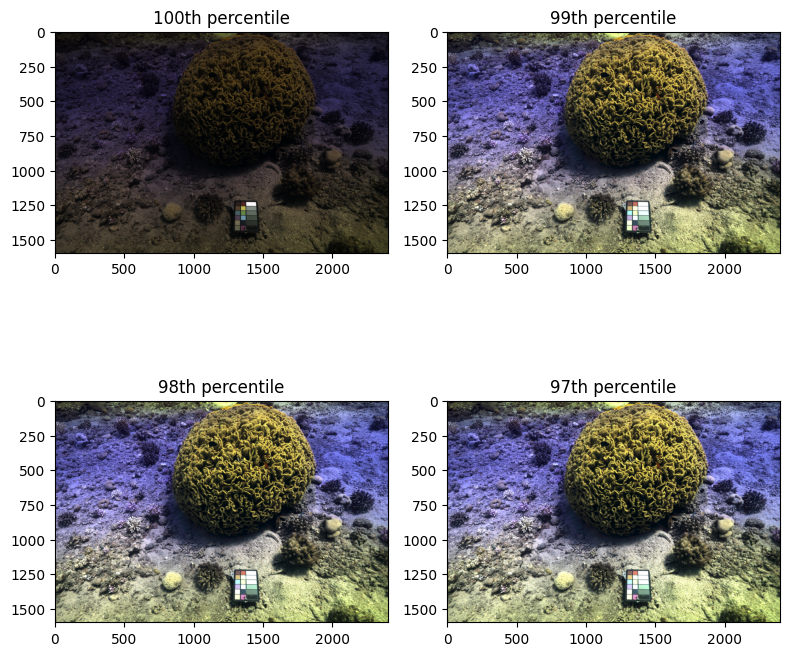

In [ ]:
pcts = [100, 99, 98, 97]
op_wp = J_8*1.0 / J_8.max(axis=(0,1))
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()

for idx, pct in enumerate(pcts):
    op_wp2 = img_as_ubyte(white_patch(op_wp, pct))
    axs[idx].imshow(cv2.cvtColor(op_wp2, cv2.COLOR_BGR2RGB))
    axs[idx].set_title(f'{pct}th percentile')

plt.tight_layout()
plt.show()

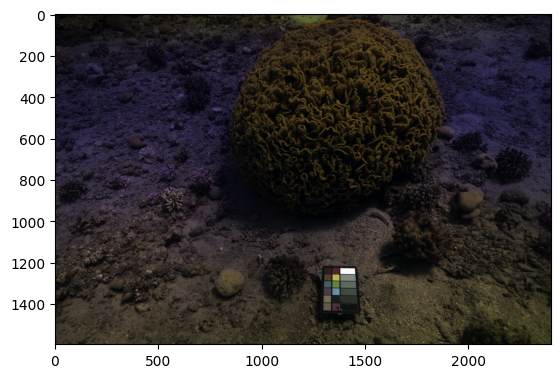

In [ ]:
op_wp = img_as_ubyte(J_8*1.0 / J_8.max(axis=(0,1)))
img = img_as_ubyte(white_patch(op_wp, 100))

imshow(img, color_channel="bgr")

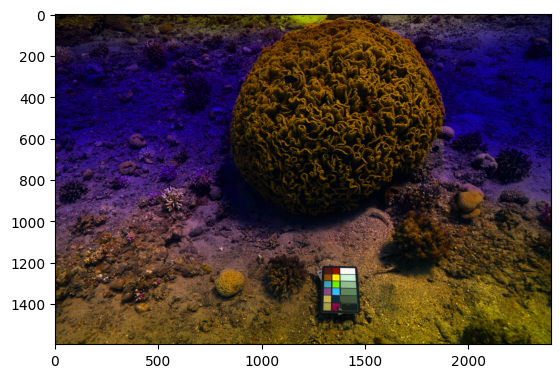

In [ ]:
hsv = uint8_2_double(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))
hsv[:, :, 1] *= 2.2
hsv[:, :, 2] *= 1.8

hsv[hsv[:, :, 1] >= 1, 1] = 1
hsv[hsv[:, :, 2] >= 1, 2] = 1

imshow(hsv, color_channel="hsv")

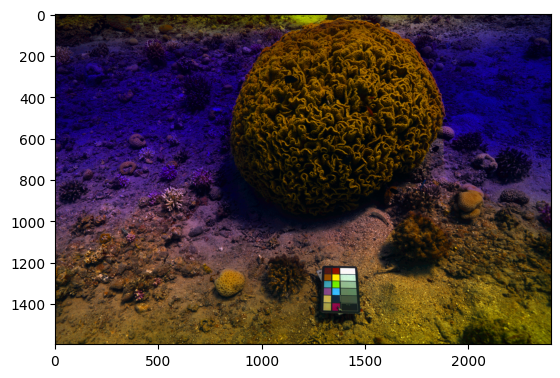

In [ ]:
img_adjusted = cv2.cvtColor(img_as_ubyte(hsv), cv2.COLOR_HSV2BGR)

imshow(img_adjusted, color_channel="bgr")

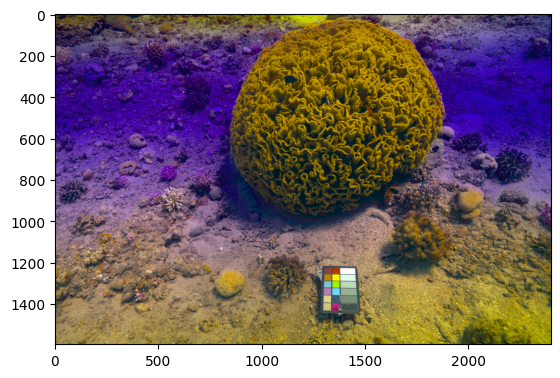

In [ ]:
img_gamma = skimage.exposure.adjust_gamma(img_adjusted, gamma=0.55)

imshow(img_gamma, color_channel="bgr")

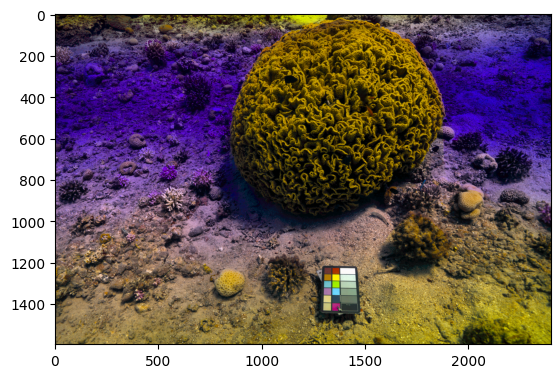

In [ ]:
img_hist = skimage.exposure.equalize_adapthist(img_gamma)

imshow(img_hist, color_channel="bgr")

In [ ]:
cv2.imwrite("output/crutchfield_perry_final.png", img_as_ubyte(img_hist))

True